In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import os
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [30]:
pd.options.display.float_format = '{:.2f}'.format

In [31]:
data = pd.read_csv("data/Base Comida Rapida.csv", encoding='utf-8', sep = ";")
classification = pd.read_excel("data/clasificacion_productos.xlsx")

# Limpieza y transformación de datos

In [32]:
data.head()

,Factura,fecha_creacion,codigo,nombre item,Cantidad,Venta,descuento,impuesto,tpv,cliente
0,A683 00002999,2023-07-27 12:22:42.000,6692,K PHILADELPHIA STEAK,1,27685.00,0.00,2215.00,IRCC2838,284
1,A683 00003065,2023-07-31 12:16:22.653,9726,K ENSALADA MEXICANA LOMO EN COMBO,1,34630.00,0.00,2770.00,IRCC2838,612
2,A683 00003370,2023-08-22 13:29:56.640,10458,PT MR TEA DISPENSADOR 473 ML,1,4537.00,0.00,363.00,IRCC2838,214
3,A683 00003394,2023-08-23 15:37:43.000,1660,LLV MALTEADA DE FRUTOS DEL BOSQUE 355 ML,1,11574.00,0.00,926.00,IRCC2838,671
4,A683 00003434,2023-08-25 13:01:47.800,11513,K TODOTERRENO CALLEJERA EN COMBO,1,36944.00,0.00,2956.00,IRCC2838,780


In [33]:
data.tail()

,Factura,fecha_creacion,codigo,nombre item,Cantidad,Venta,descuento,impuesto,tpv,cliente
601329,044F 00012477,2024-06-17 13:19:38.053,44295,CORRALAZO BBQ CRUNCHY EN COMBO,1,0.00,0.00,0.00,IRCC73,141
601330,044F 00012479,2024-06-17 14:08:35.567,44295,CORRALAZO BBQ CRUNCHY EN COMBO,1,0.00,0.00,0.00,IRCC73,459
601331,A019 00172609,2023-07-03 20:40:49.337,2351,LLV VAQUERO ESPECIAL,2,49815.00,0.00,3985.00,IRCC73,342
601332,A019 00172609,2023-07-03 20:40:49.480,2351,LLV VAQUERO ESPECIAL,1,24907.00,0.00,1993.00,IRCC73,342
601333,A019 00172701,2023-07-05 18:38:24.120,8021,LLV CORRAL QUESO TOCINETA,1,25833.00,0.00,2067.00,IRCC73,212


In [34]:
data.shape

(601334, 10)

- Se cuenta con información de 601334 productos transados, caracterizados en 9 variables.

In [35]:
data['Factura'].nunique()

117197

- Se cuenta con información de 117197 ordenes de compra, caracterizadas en 9 variables.

In [36]:
data['cliente'].nunique()

1000

- Hay transacciones correspondientes a 1000 clientes diferentes.

In [37]:
data.dtypes

Factura            object
fecha_creacion     object
codigo              int64
nombre item        object
Cantidad            int64
Venta             float64
descuento         float64
impuesto          float64
tpv                object
cliente             int64
dtype: object

In [38]:
data['fecha_creacion'] = pd.to_datetime(data['fecha_creacion'])
data[['codigo', 'Factura', 'fecha_creacion', 'nombre item', 'tpv', 'cliente']] = data[['codigo', 'Factura', 'fecha_creacion', 
                                                                                       'nombre item', 'tpv', 'cliente']].astype(str)

In [39]:
print(min(data['fecha_creacion']))
print(max(data['fecha_creacion']))

2023-06-19 09:44:36.353
2024-06-18 10:00:51.010


- Se cuenta con información de aproximadamente un año, con observaciones diarias que tienen el detalle de la hora en que se llevo a cabo la transacción.

In [40]:
data.describe()

,Cantidad,Venta,descuento,impuesto
count,601334.00,601334.00,601334.00,601334.00
mean,1.06,9386.74,26.31,752.04
std,0.85,12261.09,490.22,980.05
min,-22.00,-458333.00,0.00,0.00
25%,1.00,4537.00,0.00,363.00
50%,1.00,6018.00,0.00,482.00
75%,1.00,13889.00,0.00,1111.00
max,97.00,1777778.00,15232.00,142222.00


- Se observa que hay un total de 601.334 productos transados.
- Se destaca la presencia de valores negativos en la variable _Cantidad_ y _Venta_. Estas transacciones podrian estar relacionadas a devoluciones de productos, por lo que no representan una venta como tal. En consecuencia, se hace necesario ajustar dichos valores.
- La menor cantidad de productos adquiridos es de -22 (devoluciones), mientras que la mayor cantidad es de 97. En este punto se destaca un rango muy amplio de la variable. Se hará un analisis de posibles outliers más adelante. En promedio, se compra 1 unidad de cada producto por orden. 
- La menor cantidad ventas por producto es de -458333 (devoluciones), mientras que la mayor cantidad es de 1777778. En este punto se destaca un rango muy amplio de la variable. Se hará un analisis de posibles outliers más adelante. En promedio, se venden 9386.74 por cada producto dentro de una orden.
- El 75% de los productos vendidos no tenian descuento aplicado. Lo que deja ver que los descuentos no son parte de la estrategia core de la compañía para generar ventas. De hecho, el mayor descuento aplicado es de 15232.

In [41]:
# Eliminar registros con ventas negativas
# Valores negativos
print(f'Total de productos devueltos: {(data['Venta'] <= 0).sum()}')

data = data[data['Venta'] >0]

Total de productos devueltos: 131347


- En total, se observa que hay 131347 productos sin volumen de venta. Asociados posiblemente a cortesias, devoluciones y bonos. Teniendo en cuenta que el foco del analisis son las ventas ejecutadas, se procede a eliminar estos registros, lo cual representa eliminar cerca del 20% del total de los datos.

# EDA 

In [42]:
data.shape

(469987, 10)

- Tras realizar el ajuste, ahora se trabajará con 469987 transacciones de compra.

In [43]:
# Nan
data.isna().sum()

Factura           0
fecha_creacion    0
codigo            0
nombre item       0
Cantidad          0
Venta             0
descuento         0
impuesto          0
tpv               0
cliente           0
dtype: int64

- Se observa que los datos no tienen valores nulos o faltantes.

In [44]:
# Valores duplicados
data['Factura'].duplicated().sum()

np.int64(352837)

- Se observa que hay un total de 484137 registros duplicados. Sin embargo, no se realizará un tratamiento para eliminarlos, pues estos duplicados se deben a que hay un registro para cada producto comprado en la misma orden. Es decir, cada orden no esta agrupada con los productos, sino que estos ultimos estan registrados de forma individual.

In [45]:
data.describe()

,Cantidad,Venta,descuento,impuesto
count,469987.00,469987.00,469987.00,469987.00
mean,1.06,12018.79,33.65,961.51
std,0.84,12647.32,554.28,1011.79
min,1.00,925.00,0.00,74.00
25%,1.00,5463.00,0.00,437.00
50%,1.00,6482.00,0.00,518.00
75%,1.00,16574.00,0.00,1326.00
max,97.00,1777778.00,15232.00,142222.00


In [46]:
print(f"Unidades vendidas: {data['Cantidad'].sum()}")
print(f"Ventas totales: {data['Venta'].sum()}")
print(f"Descuento total: {data['descuento'].sum()}")
print(f"Impuesto total: {data['impuesto'].sum()}")

Unidades vendidas: 499166
Ventas totales: 5648675145.0
Descuento total: 15814977.0
Impuesto total: 451899290.0


In [47]:
print(f"Ordenes de compra: {data['Factura'].nunique()}")
print(f"Cantidad de clientes: {data['cliente'].nunique()}")

Ordenes de compra: 117150
Cantidad de clientes: 1000


In [48]:
data['descuento'] = np.where(data['descuento'] > 0, 1, 0)
data['nombre item'] = data['nombre item'].str.split().str.join(' ')
data = data.merge(classification, how = "left", left_on="nombre item", right_on="Tipo")
data.drop(columns=['Tipo', 'impuesto', 'tpv', 'codigo'], inplace=True)


In [49]:
# Dia de la semana
data['dia_semana'] = pd.to_datetime(data['fecha_creacion']).dt.day_name()

# Franja horaria
data['fecha_creacion'] = pd.to_datetime(data['fecha_creacion'])
data['franja_horaria'] = ['Mañana' if 5 <= x.hour < 12 else 'Tarde' if 12 <= x.hour < 18 else 'Noche' for x in data['fecha_creacion']]

dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['dia_semana'] = pd.Categorical(data['dia_semana'], categories=dias_ordenados, ordered=True)

franja_horaria_ordenada = ['Mañana', 'Tarde', 'Noche']
data['franja_horaria'] = pd.Categorical(data['franja_horaria'], categories=franja_horaria_ordenada, ordered=True)

In [50]:
# Crear una nueva columna que capture el mes y año
data['Mes'] = data['fecha_creacion'].dt.to_period('M')
evolutivo_ventas = data.groupby('Mes')['Venta'].sum().reset_index()
evolutivo_ventas['Mes'] = evolutivo_ventas['Mes'].astype(str)

fig = px.line(evolutivo_ventas, x='Mes', y='Venta', title='Evolutivo de ventas por mes', 
              labels={'Venta': 'Total ventas', 'Mes': 'Mes'}, markers=True)

fig.update_traces(line=dict(color='#EB664A', width=4), marker=dict(color='#EB664A', size=10)) 
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')
fig.show()

In [51]:
data['Hora'] = data['fecha_creacion'].dt.hour
evolutivo_ventas_hora = data.groupby('Hora')['Venta'].sum().reset_index()

fig = px.line(evolutivo_ventas_hora, x='Hora', y='Venta', title='Evolutivo de ventas por hora', 
              labels={'Venta': 'Total ventas', 'Hora': 'Hora'}, markers=True)
fig.update_traces(line=dict(color='#EB664A', width=4), marker=dict(color='#EB664A', size=10)) 
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')

fig.show()

In [52]:
data['Hora'] = data['fecha_creacion'].dt.hour
data['Dia de la Semana'] = data['fecha_creacion'].dt.day_name()



# Agrupar por Hora y Día de la Semana y sumar las Ventas
evolutivo_ventas_hora_dia = data.groupby(['Hora', 'Dia de la Semana'])['Venta'].sum().reset_index()

# Crear el gráfico
fig = px.line(evolutivo_ventas_hora_dia, x='Hora', y='Venta', color='Dia de la Semana', 
              title='Evolutivo de ventas por hora y día de la semana', 
              labels={'Venta': 'Total ventas', 'Hora': 'Hora', 'Dia de la Semana': 'Día de la Semana'}, 
              markers=True)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')
fig.show()

In [53]:
# Procesar datos y agrupar por franja horaria
ventas_dia_semana = (data
    .groupby('dia_semana')['Venta'].sum()
    .reset_index(name='Total_Ventas')
)

# Crear el gráfico
fig = px.bar(ventas_dia_semana, x='dia_semana', y='Total_Ventas', 
             title='Ventas por día de la semana', labels={'Total_Ventas': 'Total Ventas', 'dia_semana': 'Día semana'}, 
             text=ventas_dia_semana['Total_Ventas'].apply(lambda x: f"${x:,.0f}"))
fig.update_traces(marker=dict(color='#EB664A'))
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')

# Mostrar el gráfico
fig.show()

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\44864063.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [54]:
import pandas as pd
import plotly.express as px

ventas_franja_horaria = (data
    .groupby('franja_horaria')['Venta'].sum()
    .reset_index(name='Total_Ventas')
)

fig = px.pie(ventas_franja_horaria, 
             names='franja_horaria', 
             values='Total_Ventas', 
             title='Ventas por franja horaria', 
             hole=0.5)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')

fig.show()

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\3936931131.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [55]:
import pandas as pd
import plotly.express as px

ventas_dia_franja = (data
    .groupby(['dia_semana', 'franja_horaria'])['Venta'].sum()
    .reset_index(name='Total_Ventas')
)

total_ventas_por_dia = ventas_dia_franja.groupby('dia_semana')['Total_Ventas'].sum().reset_index()
total_ventas_por_dia.rename(columns={'Total_Ventas': 'Total_Ventas_Dia'}, inplace=True)
ventas_dia_franja = ventas_dia_franja.merge(total_ventas_por_dia, on='dia_semana')
ventas_dia_franja['Porcentaje'] = (ventas_dia_franja['Total_Ventas'] / ventas_dia_franja['Total_Ventas_Dia']) * 100


fig = px.bar(
    ventas_dia_franja,
    x='dia_semana',
    y='Total_Ventas',
    color='franja_horaria',
    title='Ventas por día de la semana y franja horaria',
    labels={'Total_Ventas': 'Total Ventas'},
    text=ventas_dia_franja['Porcentaje'].round(1).astype(str) + '%',
)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')

fig.show()

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\2833713246.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\2833713246.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [56]:
ventas_producto_dia = (data
    .groupby(['dia_semana', 'nombre item'])['Venta']
    .sum()
    .reset_index()
)

top_5_productos_dia = (ventas_producto_dia
    .sort_values(by=['dia_semana', 'Venta'], ascending=False)
    .groupby('dia_semana')
    .head(5)
)

fig = px.treemap(
    top_5_productos_dia,
    path=['dia_semana', 'nombre item'],
    values='Venta',
    title='Top 5 productos vendidos por día de la semana',
    color='Venta',
    color_continuous_scale='Teal',
    labels={'Venta': 'Total Ventas'}, width=1000, height = 800
)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')
fig.update_traces(textfont=dict(size=16, color='black'))

fig.show()

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\3344722203.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\3344722203.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\JUANC\OneDrive\Documents\Pruebas Tecnicas\Skandia\.venv\Lib\site-packages\plotly\express\_core.py:1727: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\JUANC\OneDrive\Documents\Pruebas

In [57]:
ventas_producto_dia = (data
    .groupby(['dia_semana', 'nombre item'])['Venta']
    .sum()
    .reset_index()
)

ventas_producto_dia = ventas_producto_dia[ventas_producto_dia['Venta'] > 0]

top_5_productos_dia = (ventas_producto_dia
    .sort_values(by=['dia_semana', 'Venta'], ascending=True)
    .groupby('dia_semana')
    .head(5) 
    .reset_index(drop=True) 
)

fig = px.treemap(
    top_5_productos_dia,
    path=['dia_semana', 'nombre item'], 
    values='Venta',
    title='Top 5 productos menos vendidos por día de la semana',
    color='Venta',
    color_continuous_scale='Oranges', 
    labels={'Venta': 'Total Ventas'},
    width=1000, height=800
)

fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')
fig.update_traces(textfont=dict(size=16, color='black'))

fig.show()

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\3691141716.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\3691141716.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\JUANC\OneDrive\Documents\Pruebas Tecnicas\Skandia\.venv\Lib\site-packages\plotly\express\_core.py:1727: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\JUANC\OneDrive\Documents\Pruebas Tecnicas\Skandia\.venv\Lib\site-packages\plotly\express\_core.py:1727: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this war

In [58]:
ventas_producto_dia = (data
    .groupby(['franja_horaria', 'nombre item'])['Venta']
    .sum()
    .reset_index()
)

top_5_productos_dia = (ventas_producto_dia
    .sort_values(by=['franja_horaria', 'Venta'], ascending=False)
    .groupby('franja_horaria')
    .head(5)
)

fig = px.treemap(
    top_5_productos_dia,
    path=['franja_horaria', 'nombre item'],
    values='Venta',
    title='Top 5 productos vendidos por franja horaria',
    color='Venta',
    color_continuous_scale='Teal',
    labels={'Venta': 'Total Ventas'}, width=1000, height = 800
)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')
fig.update_traces(textfont=dict(size=16, color='black'))

fig.show()

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\3695203854.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\3695203854.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\JUANC\OneDrive\Documents\Pruebas Tecnicas\Skandia\.venv\Lib\site-packages\plotly\express\_core.py:1727: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\JUANC\OneDrive\Documents\Pruebas

In [59]:
ventas_producto_dia = (data
    .groupby(['franja_horaria', 'nombre item'])['Venta']
    .sum()
    .reset_index()
)

ventas_producto_dia = ventas_producto_dia[ventas_producto_dia['Venta'] > 0]

top_5_productos_dia = (ventas_producto_dia
    .sort_values(by=['franja_horaria', 'Venta'], ascending=True)
    .groupby('franja_horaria')
    .head(5) 
    .reset_index(drop=True) 
)

fig = px.treemap(
    top_5_productos_dia,
    path=['franja_horaria', 'nombre item'], 
    values='Venta',
    title='Top 5 productos menos vendidos por franja horaria',
    color='Venta',
    color_continuous_scale='Oranges', 
    labels={'Venta': 'Total Ventas'},
    width=1000, height=800
)

fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')
fig.update_traces(textfont=dict(size=16, color='black'))

fig.show()

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\694769808.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\694769808.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\JUANC\OneDrive\Documents\Pruebas Tecnicas\Skandia\.venv\Lib\site-packages\plotly\express\_core.py:1727: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\JUANC\OneDrive\Documents\Pruebas 

In [60]:
ventas_producto_dia = (data
    .groupby(['Item', 'nombre item'])['Venta']
    .sum()
    .reset_index()
)

top_5_productos_dia = (ventas_producto_dia
    .sort_values(by=['Item', 'Venta'], ascending=False)
    .groupby('Item')
    .head(5)
)

fig = px.treemap(
    top_5_productos_dia,
    path=['Item', 'nombre item'],
    values='Venta',
    title='Top 5 productos vendidos por segmento',
    color='Venta',
    color_continuous_scale='Teal',
    labels={'Venta': 'Total Ventas'}, width=1000, height = 800
)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')
fig.update_traces(textfont=dict(size=16, color='black'))

fig.show()

In [61]:
import pandas as pd
import plotly.express as px

ventas_dia_franja = (data
    .groupby(['Item', 'franja_horaria'])['Venta'].sum()
    .reset_index(name='Total_Ventas')
)

total_ventas_por_dia = ventas_dia_franja.groupby('Item')['Total_Ventas'].sum().reset_index()
total_ventas_por_dia.rename(columns={'Total_Ventas': 'Total_Ventas_Dia'}, inplace=True)
ventas_dia_franja = ventas_dia_franja.merge(total_ventas_por_dia, on='Item')
ventas_dia_franja['Porcentaje'] = (ventas_dia_franja['Total_Ventas'] / ventas_dia_franja['Total_Ventas_Dia']) * 100


fig = px.bar(
    ventas_dia_franja,
    x='Item',
    y='Total_Ventas',
    color='franja_horaria',
    title='Ventas por día de la semana y franja horaria',
    labels={'Total_Ventas': 'Total Ventas'},
    text=ventas_dia_franja['Porcentaje'].round(1).astype(str) + '%',
)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')

fig.show()

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\211133553.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [62]:
import pandas as pd
import plotly.express as px

ventas_dia_franja = (data
    .groupby(['Item', 'dia_semana'])['Venta'].sum()
    .reset_index(name='Total_Ventas')
)

total_ventas_por_dia = ventas_dia_franja.groupby('Item')['Total_Ventas'].sum().reset_index()
total_ventas_por_dia.rename(columns={'Total_Ventas': 'Total_Ventas_Dia'}, inplace=True)
ventas_dia_franja = ventas_dia_franja.merge(total_ventas_por_dia, on='Item')
ventas_dia_franja['Porcentaje'] = (ventas_dia_franja['Total_Ventas'] / ventas_dia_franja['Total_Ventas_Dia']) * 100


fig = px.bar(
    ventas_dia_franja,
    x='Item',
    y='Total_Ventas',
    color='dia_semana',
    title='Ventas por día de la semana y franja horaria',
    labels={'Total_Ventas': 'Total Ventas'},
    text=ventas_dia_franja['Porcentaje'].round(1).astype(str) + '%',
)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')

fig.show()

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\2961965137.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [63]:
ventas_producto_dia = (data
    .groupby(['Clasificacion', 'nombre item'])['Venta']
    .sum()
    .reset_index()
)

top_5_productos_dia = (ventas_producto_dia
    .sort_values(by=['Clasificacion', 'Venta'], ascending=False)
    .groupby('Clasificacion')
    .head(5)
)

fig = px.treemap(
    top_5_productos_dia,
    path=['Clasificacion', 'nombre item'],
    values='Venta',
    title='Top 5 productos vendidos por linea de producto',
    color='Venta',
    color_continuous_scale='Teal',
    labels={'Venta': 'Total Ventas'}, width=1000, height = 800
)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')
fig.update_traces(textfont=dict(size=16, color='black'))

fig.show()

# Segmentación

In [64]:
df_cluster = data.copy()

In [65]:
# Frecuencia de compra
df_frecuencia = df_cluster[["fecha_creacion", "cliente"]]
df_frecuencia['fecha_creacion'] =df_frecuencia['fecha_creacion'].dt.date
df_frecuencia.drop_duplicates(inplace=True)
df_frecuencia.sort_values(by='fecha_creacion', inplace=True)

df_frecuencia['fecha_creacion'] = pd.to_datetime(df_frecuencia['fecha_creacion'])
df_frecuencia['frecuencia'] =df_frecuencia.groupby('cliente')['fecha_creacion'].diff().dt.days
df_frecuencia = df_frecuencia.groupby('cliente')['frecuencia'].mean().reset_index()
df_frecuencia.set_index("cliente", inplace=True)

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\1856689428.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\1856689428.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JUANC\AppData\Local\Temp\ipykernel_9672\1856689428.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JUANC\AppData\Local\Temp\ipykernel_96

In [66]:
df_cluster.drop(columns=["nombre item", "Mes", "Hora", "Dia de la Semana", "Item", "Cantidad"], inplace=True)
df_cluster.set_index("cliente", inplace=True)

In [67]:
cuali = df_cluster[['Clasificacion', 'dia_semana', 'franja_horaria', 'Venta']]
cuali = pd.get_dummies(cuali, columns=['Clasificacion', 'dia_semana', 'franja_horaria'], prefix='', prefix_sep='')
# Convertir las columnas de clasificación a 1 y 0
cuali[cuali.columns.difference(['Factura', 
                                            'fecha_creacion', 
                                            'Venta', 
                                            'cliente'])] = cuali[cuali.columns.difference(['Factura', 
                                                                                                       'fecha_creacion', 
                                                                                                       'Venta', 
                                                                                                       'cliente'])].astype(int)

In [68]:
for col in cuali.columns:
    if col != 'Venta':
        cuali[col] = cuali[col] * cuali['Venta']
        
cuali.drop(columns='Venta', inplace=True)

In [69]:
cuali = cuali.groupby(cuali.index).sum()
cuali

,Acompañamientos,Adiciones,Agua,Cafe,Cerveza,Corralito,Desayunos,Ensaladas,Gaseosa,Helado,...,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Mañana,Tarde,Noche
cliente,,,,,,,,,,,,,,,,,,,,,
1,966094.00,61113.00,151203.00,4167.00,0.00,9722.00,0.00,134536.00,439259.00,91576.00,...,730879.00,793887.00,1184717.00,706112.00,1311756.00,607683.00,531248.00,290553.00,3700735.00,1874994.00
10,908921.00,35649.00,166854.00,9444.00,0.00,20278.00,12870.00,224907.00,387219.00,72501.00,...,459076.00,730555.00,915830.00,1093882.00,997123.00,432684.00,599816.00,75742.00,4015451.00,1137773.00
100,1289020.00,40279.00,259539.00,6111.00,14075.00,51945.00,17500.00,222869.00,563150.00,154540.00,...,905647.00,1035556.00,1335379.00,1323239.00,1282825.00,605834.00,1055926.00,419353.00,5302834.00,1822219.00
1000,864808.00,62039.00,169260.00,0.00,5463.00,30092.00,12870.00,120277.00,403890.00,108340.00,...,611207.00,411757.00,820462.00,895136.00,1445834.00,363427.00,339813.00,175835.00,3078138.00,1633663.00
101,752529.00,21760.00,117593.00,1852.00,16389.00,0.00,16574.00,183425.00,388243.00,142594.00,...,187040.00,1144533.00,948148.00,758053.00,823056.00,402960.00,366298.00,207222.00,3006019.00,1416847.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,943049.00,38425.00,205835.00,0.00,5463.00,38333.00,25740.00,207962.00,450185.00,70375.00,...,909164.00,1078145.00,561298.00,1102499.00,449909.00,682877.00,771018.00,159632.00,4346945.00,1048333.00
996,827057.00,51855.00,138148.00,0.00,27315.00,19444.00,0.00,114907.00,357316.00,90652.00,...,295555.00,639214.00,1036017.00,571201.00,937866.00,595969.00,502869.00,104350.00,3123604.00,1350737.00
997,677311.00,25002.00,131205.00,4167.00,5463.00,0.00,37778.00,132315.00,302869.00,88890.00,...,302038.00,940001.00,423888.00,901022.00,881294.00,442961.00,507043.00,250372.00,2935098.00,1212777.00


In [70]:
df = pd.concat([cuali, df_frecuencia], axis=1)

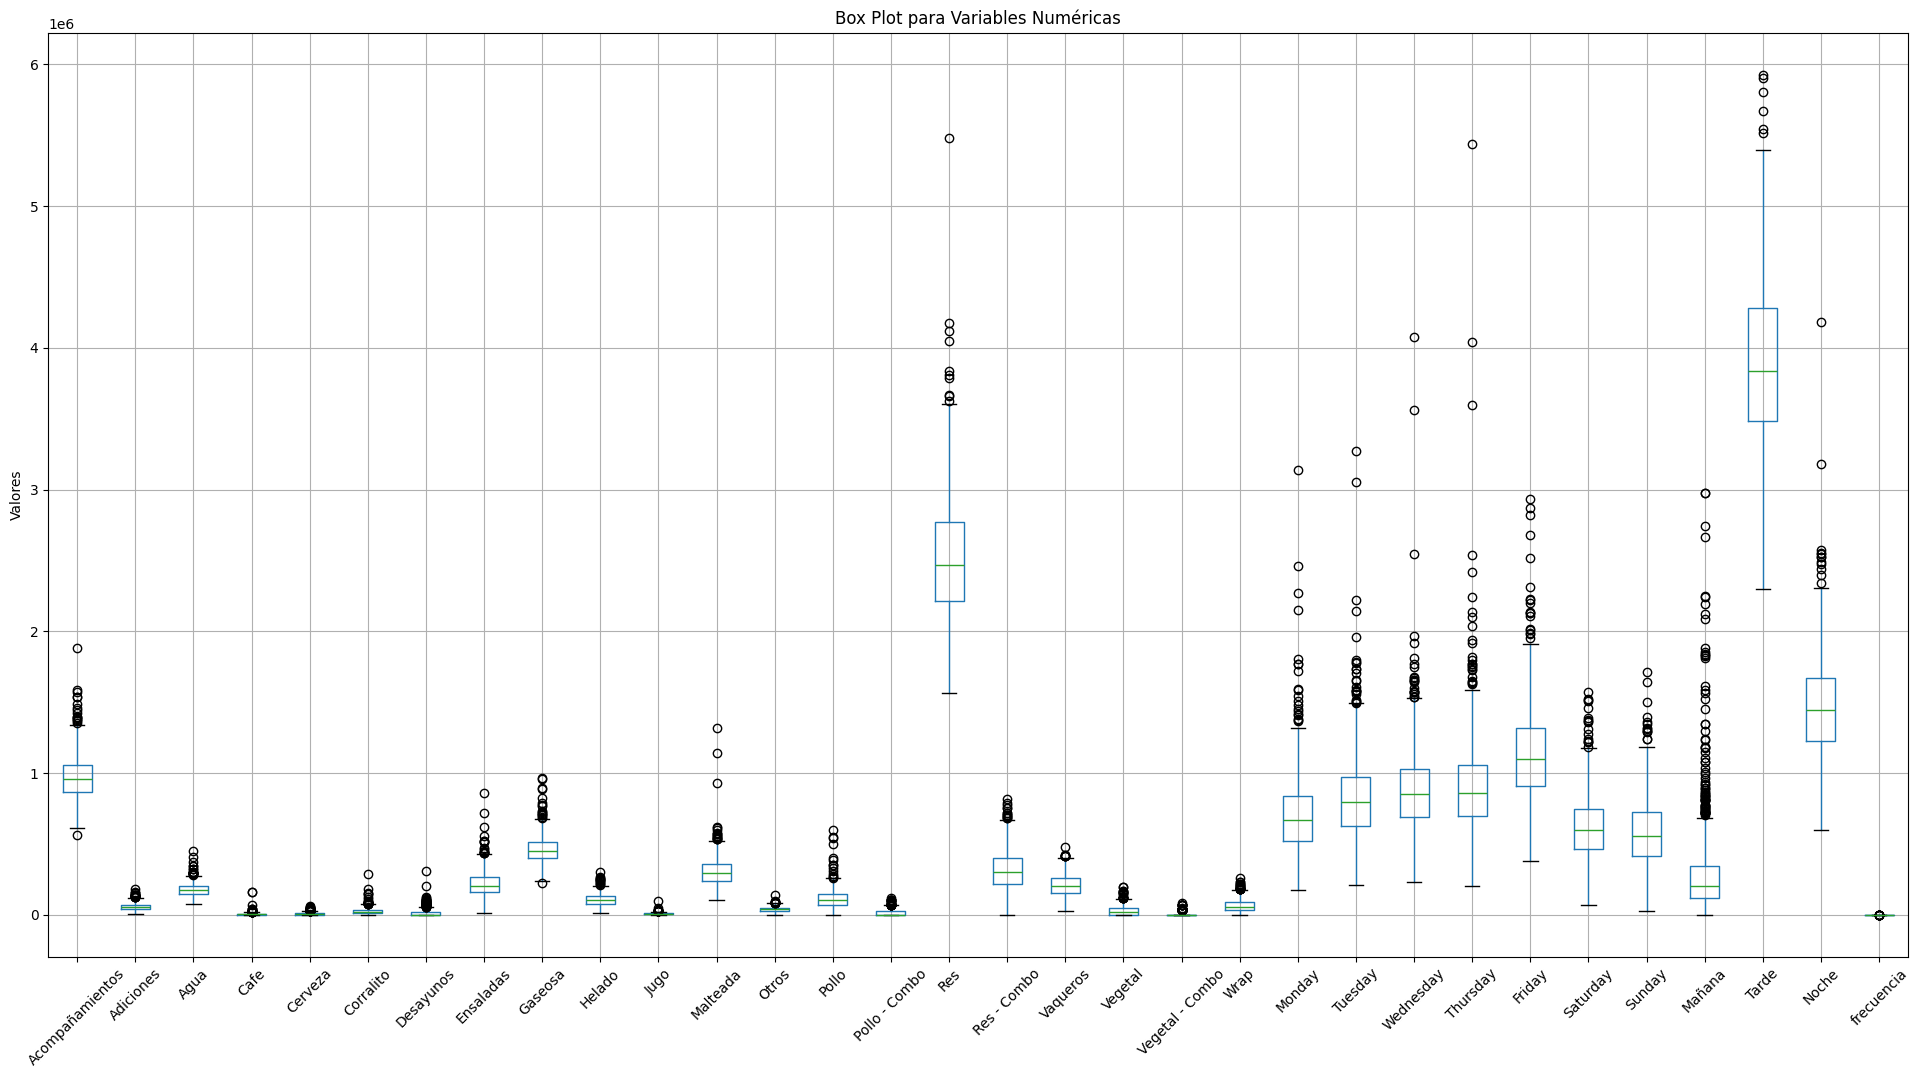

In [71]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(24, 12))
df[numerical_columns].boxplot()
plt.xticks(rotation=45)
plt.title('Box Plot para Variables Numéricas')
plt.ylabel('Valores')
plt.show()

In [72]:
def detectar_outliers_1(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    print(f"Outliers en '{columna}': {len(outliers)}")
    return outliers

for columna in df.select_dtypes(include=['float64', 'int64']).columns:
    outliers = detectar_outliers_1(df, columna)
    f"Outliers en la columna {columna}: {outliers}"

Outliers en 'Acompañamientos': 17
Outliers en 'Adiciones': 18
Outliers en 'Agua': 19
Outliers en 'Cafe': 28
Outliers en 'Cerveza': 38
Outliers en 'Corralito': 22
Outliers en 'Desayunos': 53
Outliers en 'Ensaladas': 16
Outliers en 'Gaseosa': 17
Outliers en 'Helado': 12
Outliers en 'Jugo': 23
Outliers en 'Malteada': 16
Outliers en 'Otros': 12
Outliers en 'Pollo': 14
Outliers en 'Pollo - Combo': 23
Outliers en 'Res': 10
Outliers en 'Res - Combo': 13
Outliers en 'Vaqueros': 8
Outliers en 'Vegetal': 17
Outliers en 'Vegetal - Combo': 96
Outliers en 'Wrap': 21
Outliers en 'Monday': 20
Outliers en 'Tuesday': 23
Outliers en 'Wednesday': 22
Outliers en 'Thursday': 24
Outliers en 'Friday': 18
Outliers en 'Saturday': 16
Outliers en 'Sunday': 13
Outliers en 'Mañana': 74
Outliers en 'Tarde': 6
Outliers en 'Noche': 12
Outliers en 'frecuencia': 12


In [73]:
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def winsorize_column(df, columna):
    lower_bound, upper_bound = detectar_outliers(df, columna)
    df[columna] = np.where(df[columna] < lower_bound, lower_bound, df[columna])
    df[columna] = np.where(df[columna] > upper_bound, upper_bound, df[columna])

for columna in df.select_dtypes(include=['float64', 'int64']).columns:
    lower_bound, upper_bound = detectar_outliers(df, columna)
    if (df[columna] < lower_bound).any() or (df[columna] > upper_bound).any():
        winsorize_column(df, columna)
        print(f"Winsorización aplicada a la columna {columna}")

Winsorización aplicada a la columna Acompañamientos
Winsorización aplicada a la columna Adiciones
Winsorización aplicada a la columna Agua
Winsorización aplicada a la columna Cafe
Winsorización aplicada a la columna Cerveza
Winsorización aplicada a la columna Corralito
Winsorización aplicada a la columna Desayunos
Winsorización aplicada a la columna Ensaladas
Winsorización aplicada a la columna Gaseosa
Winsorización aplicada a la columna Helado
Winsorización aplicada a la columna Jugo
Winsorización aplicada a la columna Malteada
Winsorización aplicada a la columna Otros
Winsorización aplicada a la columna Pollo
Winsorización aplicada a la columna Pollo - Combo
Winsorización aplicada a la columna Res
Winsorización aplicada a la columna Res - Combo
Winsorización aplicada a la columna Vaqueros
Winsorización aplicada a la columna Vegetal
Winsorización aplicada a la columna Vegetal - Combo
Winsorización aplicada a la columna Wrap
Winsorización aplicada a la columna Monday
Winsorización apli

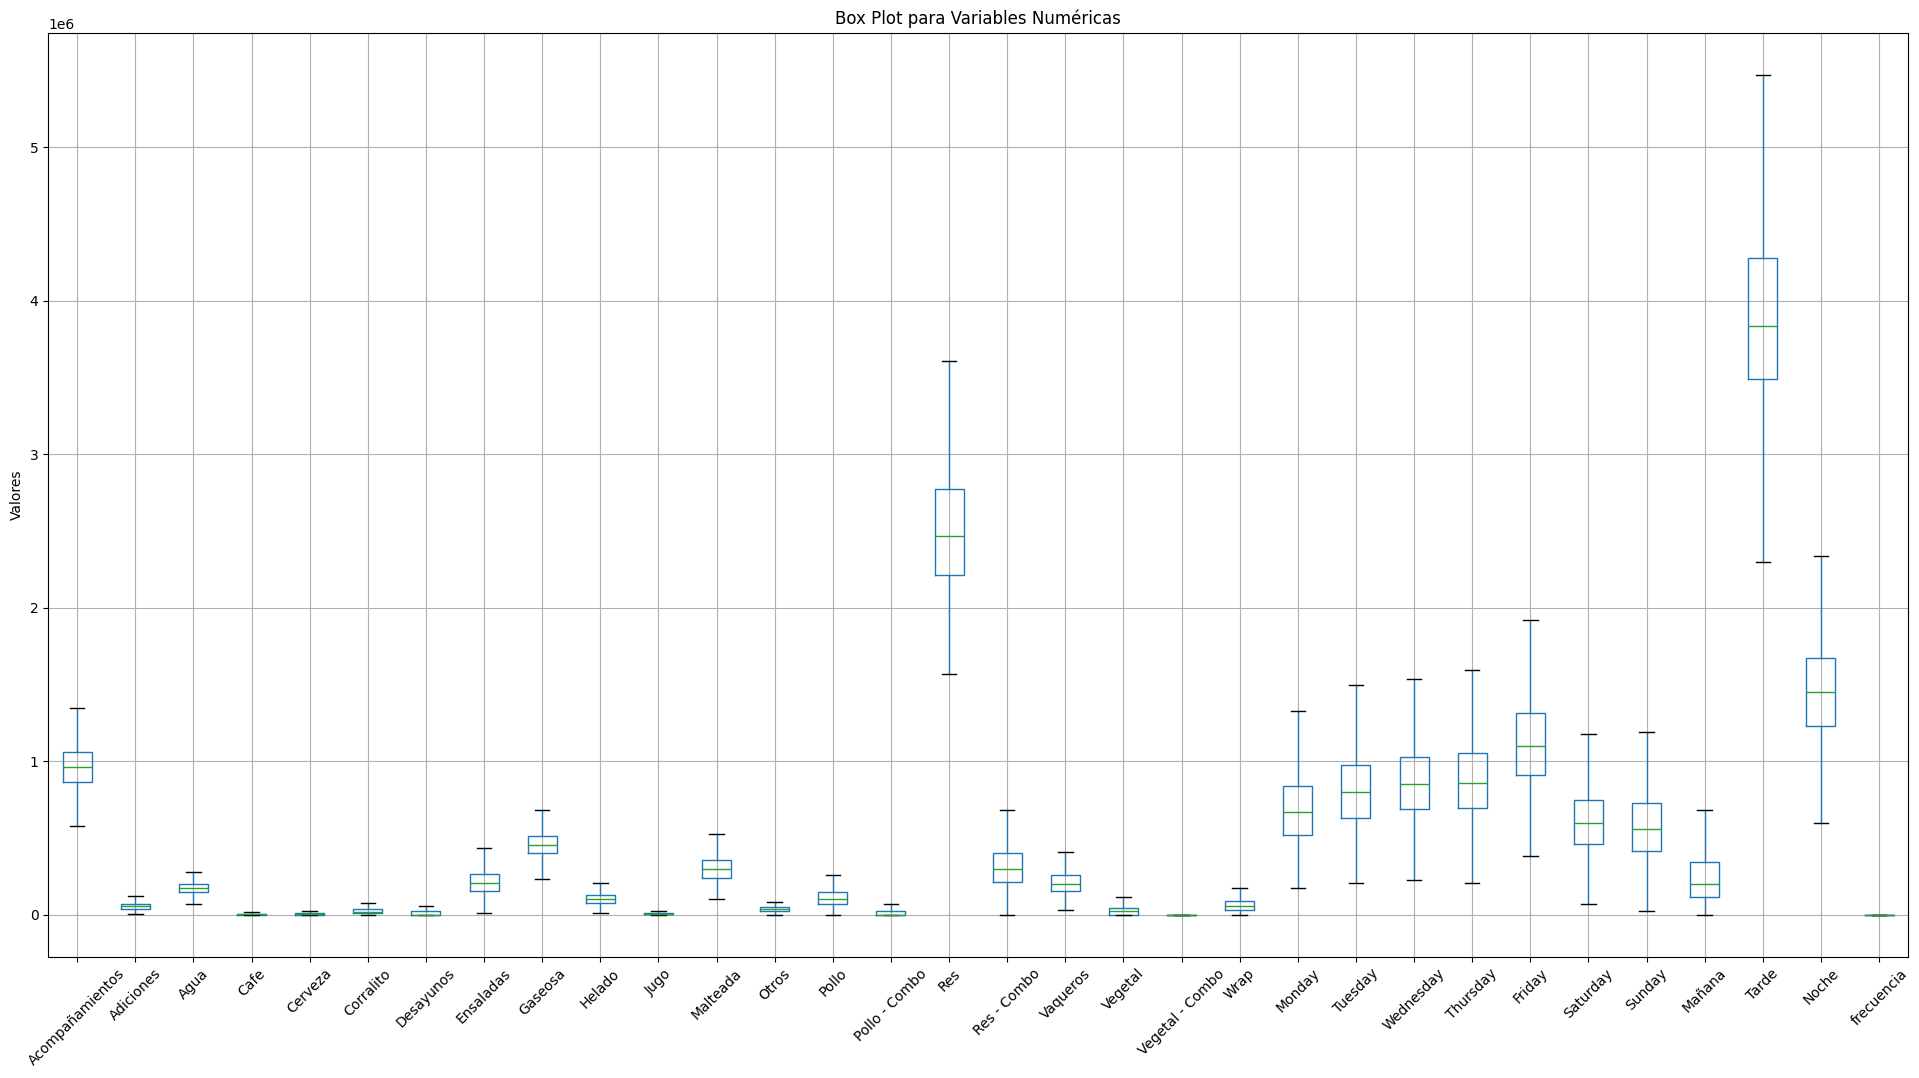

In [74]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(24, 12))
df[numerical_columns].boxplot()
plt.xticks(rotation=45)
plt.title('Box Plot para Variables Numéricas')
plt.ylabel('Valores')
plt.show()

In [75]:
def detectar_outliers_1(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    print(f"Outliers en '{columna}': {len(outliers)}")
    return outliers

for columna in df.select_dtypes(include=['float64', 'int64']).columns:
    outliers = detectar_outliers_1(df, columna)
    f"Outliers en la columna {columna}: {outliers}"

Outliers en 'Acompañamientos': 0
Outliers en 'Adiciones': 0
Outliers en 'Agua': 0
Outliers en 'Cafe': 0
Outliers en 'Cerveza': 0
Outliers en 'Corralito': 0
Outliers en 'Desayunos': 0
Outliers en 'Ensaladas': 0
Outliers en 'Gaseosa': 0
Outliers en 'Helado': 0
Outliers en 'Jugo': 0
Outliers en 'Malteada': 0
Outliers en 'Otros': 0
Outliers en 'Pollo': 0
Outliers en 'Pollo - Combo': 0
Outliers en 'Res': 0
Outliers en 'Res - Combo': 0
Outliers en 'Vaqueros': 0
Outliers en 'Vegetal': 0
Outliers en 'Vegetal - Combo': 0
Outliers en 'Wrap': 0
Outliers en 'Monday': 0
Outliers en 'Tuesday': 0
Outliers en 'Wednesday': 0
Outliers en 'Thursday': 0
Outliers en 'Friday': 0
Outliers en 'Saturday': 0
Outliers en 'Sunday': 0
Outliers en 'Mañana': 0
Outliers en 'Tarde': 0
Outliers en 'Noche': 0
Outliers en 'frecuencia': 0


### Estandarización

In [76]:
from sklearn.preprocessing import StandardScaler
escala=StandardScaler(with_mean=True, with_std=True)
escala.fit(df)
df_estand = escala.transform(df)


In [77]:
df_estand = pd.DataFrame(df_estand, index=df.index)
df_estand.columns = df.columns

In [78]:
from sklearn.cluster import KMeans
within= [] 
for k in range(1,20):
    kmeanModel = KMeans(n_clusters=k, n_init=10).fit(df_estand)
    within.append(kmeanModel.inertia_)
fig=px.line(x=list(range(1,20)), y=within,  title="Within Variance")
fig.show()

c:\Users\JUANC\OneDrive\Documents\Pruebas Tecnicas\Skandia\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\JUANC\OneDrive\Documents\Pruebas Tecnicas\Skandia\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


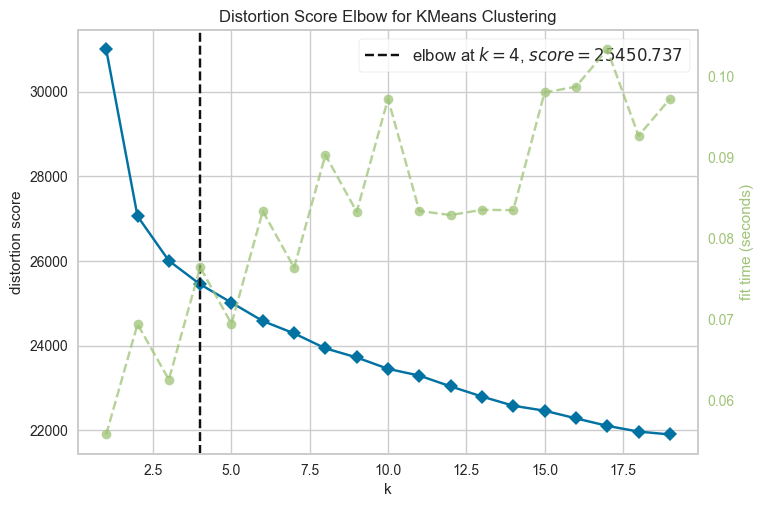

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [79]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(df_estand)        # Fit the data to the visualizer
visualizer.show()

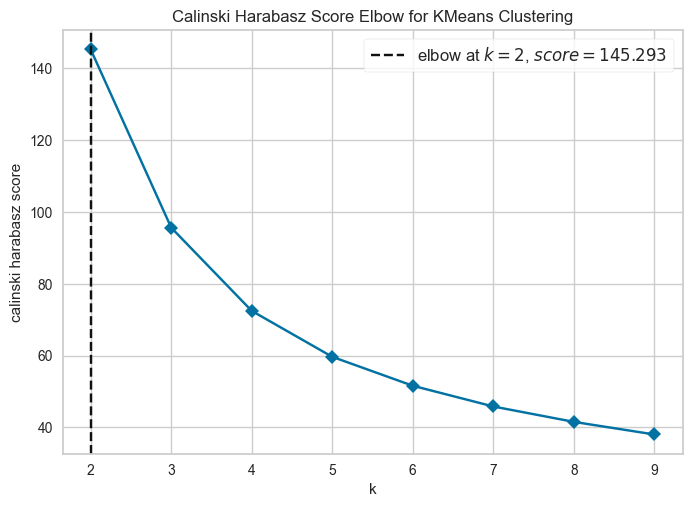

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [80]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(
    model, k=(2,10), metric='calinski_harabasz', timings=False
)

visualizer.fit(df_estand)        # Fit the data to the visualizer
visualizer.show()

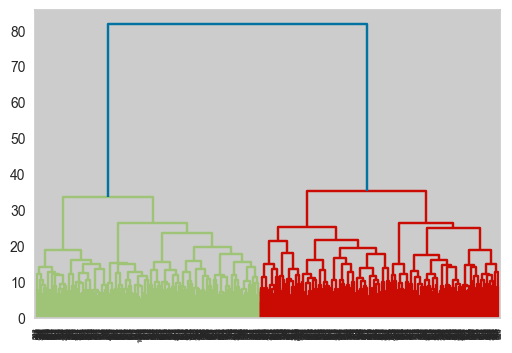

In [81]:
from scipy.cluster.hierarchy import dendrogram ### pintar dendrograma
from sklearn.cluster import AgglomerativeClustering ## Calcular Agrupamiento jerarquico
import scipy.cluster.hierarchy as sch ## DIstancias
plt.rcParams["figure.figsize"] = (6,4)
dendogram=sch.dendrogram(sch.linkage(df_estand, method='ward',metric="euclidean"),labels=df_estand.index)

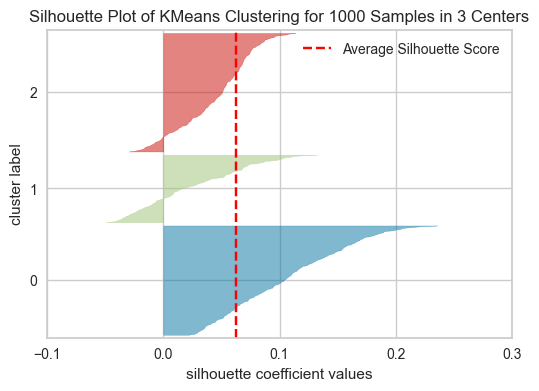

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=10, random_state=42))

In [82]:
silhouette_visualizer(KMeans(3, random_state=42, n_init=10), df_estand, colors='yellowbrick')

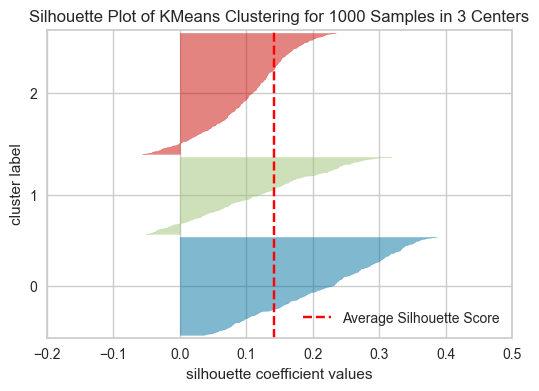

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=10, random_state=42))

In [83]:
silhouette_visualizer(KMeans(3, random_state=42, n_init=10), df, colors='yellowbrick')

In [84]:
kmedias = KMeans(n_clusters=3, n_init=10).fit(df)

In [85]:
kmedias.labels_

array([0, 0, 2, 1, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 1,
       2, 0, 0, 1, 0, 1, 0, 2, 1, 2, 0, 2, 0, 1, 1, 2, 0, 1, 0, 2, 0, 0,
       1, 1, 0, 0, 2, 1, 0, 1, 0, 2, 0, 2, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0,
       1, 0, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 0, 1, 2, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 2, 1, 0, 0, 1, 2, 0,
       1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 0, 1, 2,
       2, 2, 0, 2, 0, 0, 0, 2, 1, 0, 1, 2, 0, 0, 0, 2, 1, 0, 1, 1, 2, 2,
       1, 1, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 1, 0, 2, 2, 1, 2, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 2, 2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 2, 1, 0, 0, 0,
       0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 1, 0, 2, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 1, 1, 2, 2, 1, 0, 2, 2, 0, 2,
       1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,

In [86]:
df["Grupo"]=kmedias.labels_

In [87]:
#df = df[['Grupo']]

In [88]:
#df = data.merge(df, how='left', left_on="cliente", right_on=df.index)

In [89]:
df.columns

Index(['Acompañamientos', 'Adiciones', 'Agua', 'Cafe', 'Cerveza', 'Corralito',
       'Desayunos', 'Ensaladas', 'Gaseosa', 'Helado', 'Jugo', 'Malteada',
       'Otros', 'Pollo', 'Pollo - Combo', 'Res', 'Res - Combo', 'Vaqueros',
       'Vegetal', 'Vegetal - Combo', 'Wrap', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'Mañana', 'Tarde', 'Noche',
       'frecuencia', 'Grupo'],
      dtype='object')

In [90]:
df_productos = df[['Acompañamientos', 'Adiciones', 'Agua', 'Cafe', 'Cerveza', 'Corralito',
       'Desayunos', 'Ensaladas', 'Gaseosa', 'Helado', 'Jugo', 'Malteada',
       'Otros', 'Pollo', 'Pollo - Combo', 'Res', 'Res - Combo', 'Vaqueros',
       'Vegetal', 'Vegetal - Combo', 'Wrap', 'Grupo']]

df_productos = df_productos.melt(id_vars=['Grupo'], 
                               value_vars=['Acompañamientos', 'Adiciones', 'Agua', 'Cafe', 
                                           'Cerveza', 'Corralito', 'Desayunos', 'Ensaladas', 
                                           'Gaseosa', 'Helado', 'Jugo', 'Malteada', 
                                           'Otros', 'Pollo', 'Pollo - Combo', 'Res', 
                                           'Res - Combo', 'Vaqueros', 'Vegetal', 
                                           'Vegetal - Combo', 'Wrap'], 
                               var_name='producto', 
                               value_name='venta')
df_productos['Grupo'] = df_productos['Grupo'].astype(str)

In [91]:
fig = px.box(df_productos, 
             x='producto', 
             y='venta', color='Grupo', width=1500, height=800)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')

# Mostrar el gráfico
fig.show()

In [92]:
df_dia_semana = df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','Grupo']]

df_dia_semana = df_dia_semana.melt(id_vars=['Grupo'], 
                               value_vars=['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'], 
                               var_name='dia', 
                               value_name='venta')
df_dia_semana['Grupo'] = df_dia_semana['Grupo'].astype(str)

In [93]:
fig = px.box(df_dia_semana, 
             x='dia', 
             y='venta', color='Grupo', width=1400, height=600)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')

# Mostrar el gráfico
fig.show()

In [94]:
df_franja_horaria = df[['Mañana', 'Tarde', 'Noche', 'Grupo']]

df_franja_horaria = df_franja_horaria.melt(id_vars=['Grupo'], 
                               value_vars=['Mañana', 'Tarde', 'Noche',], 
                               var_name='franja', 
                               value_name='venta')
df_franja_horaria['Grupo'] = df_franja_horaria['Grupo'].astype(str)

In [95]:
fig = px.box(df_franja_horaria, 
             x='franja', 
             y='venta', color='Grupo', width=1400, height=600)
fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')

# Mostrar el gráfico
fig.show()

Estrategias: potenciar el consumo en la franja nocturna. Habria que revisar la apuesta del restaurante en la franja morning, pues no presenta buen desempeño.
potenciar el consumo los fines de semana, llama la atencion las ventas como caen en esta franja.
la franja horaria con mayor consumo es en la tarde, especificamente en la hora del almuerzo. Revisar como esto converge con la hora del almuerzo de trabajadores.

In [96]:
fig = px.box(df, 
             x='Grupo', 
             y='frecuencia', color='Grupo', width=1000, height=400)

fig.update_layout(plot_bgcolor='#FFF4E0', 
                  paper_bgcolor='#FFF4E0')

# Mostrar el gráfico
fig.show()

Los clientes en azul han consumido, en promedio, cerca de 2.5M en hamburgeusas de res, siendo este el producto más demandado por ellos. Son clientes que usualmente consumen estas hamburguesas con acompañamientos (975mil), y prefieren como bebidas las gaseosas (458mil) y ocasionalmente el agua (117mil). Hay otra serie de productos con un nivel de consumo intermedio-bajo, como combos de hamburguesas de Res, Vauqeros, Malteadas y Ensaladas. En terminos generales, son clientes con un nivel de consumo intermedio-alto. Además, son clientes que tienen un nivel de compra intermedio en cada día de la semana respecto a los demás clientes. Siendo el día de mayor consumo el viernes y el de menor consumo el domingo. Son clientes con un consumo intermedio en cada franja horaria respecto a los demás clientes, aunque su mayor demanda se da en la franja de la tarde. Y su menor demanda en la franja de la mañana. Son clientes con una frecuencia de compra intermedia, la cual es de 3.6 días en promedio.


Los clientes en rojo han consumido, en promedio, cerca de 2.9M en hamburgeusas de res, siendo este el producto más demandado por ellos. Son clientes que siempre buscan acompañar sus pedidos de acompañamientos extras (1.1M), y prefieren como bebidas las gaseosas (535mil) y ocasionalmente el agua (198mil). Hay otra serie de productos con un nivel de consumo intermedio-bajo, aunque aun así son los clientes con mayor nivel de consumo en estos productos como: combos de hamburguesas de Res, Vaqueros, Malteadas, Ensaladas, Hamburguesas de Pollo y Helados. En terminos generales, son clientes con un nivel de consumo alto. Además, son los clientes que tienen un mayor nivel de compra en cada día de la semana respecto a los demás clientes. Siendo el día de mayor consumo el viernes y el de menor consumo el domingo. Son clientes con un consumo mayoritario en cada franja horaria respecto a los demás clientes, aunque su mayor demanda se da en la franja de la tarde. Y su menor demanda en la franja de la mañana. Son los clientes con la menor frecuencia de compra, la cual es de 3.4 días en promedio.


Los clientes en verde han consumido, en promedio, cerca de 2.1M en hamburgeusas de res, siendo este el producto más demandado por ellos. Son clientes que algunas veces buscan acompañar sus pedidos de acompañamientos extras (829 mil), y prefieren como bebidas las gaseosas (385mil) y ocasionalmente el agua (153mil), aunque son los clientes que menos consumen este ultimo. Hay otra serie de productos con un nivel de consumo intermedio-bajo, aunque son los clientes con menor nivel de consumo en estos productos como: combos de hamburguesas de Res, Vaqueros, Malteadas, Ensaladas, Hamburguesas de Pollo y Helados. En terminos generales, son clientes con un nivel de consumo intermedio-bajo. Además, son los clientes que tienen un menor nivel de compra en cada día de la semana respecto a los demás clientes. Siendo el día de mayor consumo el viernes y el de menor consumo el domingo. Son clientes con un consumo bajo en cada franja horaria respecto a los demás clientes, aunque su mayor demanda se da en la franja de la tarde. Y su menor demanda en la franja de la mañana. Son los clientes con la mayor frecuencia de compra, la cual es de 3.9 días en promedio.